In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import logit

from IPython.display import display

from keras.layers import (Input, Dense, Lambda, Flatten, Reshape, BatchNormalization, Layer,
                          Activation, Dropout, Conv2D, Conv2DTranspose,
                          Concatenate, Add, Multiply)
from keras.engine import InputSpec
from keras.losses import sparse_categorical_crossentropy
from keras.optimizers import RMSprop, Adam
from keras.models import Model
from keras import metrics
from keras import backend as K
from keras_tqdm import TQDMNotebookCallback
from keras.datasets import cifar10
from realnvp_helpers import Mask


%matplotlib inline

/home/brian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
shape = (4, 4, 3)
samples = 10

train_data = np.random.normal(0.5, 3, size=(samples,) + (shape))

In [3]:
def conv_block(input_tensor, kernel_size, filters, stage, block):
    ''' Adapted from resnet50 implementation in Keras '''
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size,
                      padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    #x = add([x, input_tensor])
    x = Activation('relu')(x)
    
    return x

In [13]:
def coupling_step(input_tensor, mask_type, stage):
    ''' Implements (as per paper):
        y = b * x + (1 - b) * [x * exp(s(b * x)) + t(b * x)]
    '''
    assert mask_type in ['check_even', 'check_odd', 'channel_even', 'channel_odd']
    mask_prefix = 'check' if mask_type.startswith('check') else 'channel'
    mask_opposite = 'odd' if mask_type.endswith('even') else 'even'
    
    b0 = Mask(mask_type)
    b1 = Mask(mask_prefix + '_' + mask_opposite)
    
    mask_even_in = b0(input_tensor)
    mask_odd_in = b1(input_tensor)
    
    s = conv_block(mask_even_in, (3, 3), (32, 32, 3), stage, '_s')
    t = conv_block(mask_even_in, (3, 3), (32, 32, 3), stage, '_t')
    
    coupling = Lambda(lambda ins:  ins[0] * K.exp(ins[1]) + ins[2])([input_tensor, s, t])
    coupling_mask = b1(coupling)
   
    # Return result + masked scale for loss function
    return Add()([mask_even_in, coupling_mask]), b1(s)

In [14]:
def coupling_layer(input_tensor, mask_type, stage):
    assert mask_type in ['check_even', 'check_odd', 'channel_even', 'channel_odd']
    mask_prefix = 'check' if mask_type.startswith('check') else 'channel'
    
    x, s1 = coupling_step(input_tensor, mask_prefix + '_even', stage=str(stage) + 'a')
    x, s2 = coupling_step(x, mask_prefix + '_odd', stage=str(stage) + 'b')
    x, s3 = coupling_step(x, mask_prefix + '_even', stage=str(stage) + 'c')
    
    return x, [s1, s2, s3]

In [18]:
def realnvp_loss(target, output, shape):
    # Extract x's and s's
    print(output.shape)
    z = output[:, :, :, :shape[-1]]
    print(z.shape)
    s = output[:, :, :, shape[-1]:]
    print(s.shape)
   
    # Prior is standard normal(mu=0, sigma=1)
    z_loss = -0.5 * np.log(math.pi) - 0.5 * z**2
   
    # Determinant is just sum of "s" params (already log-space)
    det_loss = K.sum(s)
    
    return -z_loss - det_loss

In [19]:
input_tensor = Input(shape=shape)
x, s = coupling_layer(input_tensor, 'check_even', stage=1)
out = Concatenate()([x] + s)

model = Model(inputs=input_tensor, outputs=out)
optimizer = Adam(lr=0.01)
model.compile(optimizer=optimizer, 
              loss=lambda target, output: realnvp_loss(target, output, shape=shape))
model.summary()

(?, 4, 4, 12)
(?, 4, 4, 3)
(?, 4, 4, 9)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 4, 4, 3)      0                                            
__________________________________________________________________________________________________
mask_25 (Mask)                  (None, 4, 4, 3)      0           input_5[0][0]                    
__________________________________________________________________________________________________
res1a_s_branch2a (Conv2D)       (None, 4, 4, 32)     128         mask_25[0][0]                    
__________________________________________________________________________________________________
res1a_t_branch2a (Conv2D)       (None, 4, 4, 32)     128         mask_25[0][0]                    
_____________________________________________________________________

In [20]:
#early_stopping = keras.callbacks.EarlyStopping('val_loss', min_delta=50.0, patience=5)
#reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0001)

history = model.fit(
    train_data, train_data,
    batch_size=5,
    epochs=50,
    callbacks=[TQDMNotebookCallback()], #, early_stopping, reduce_lr],
    verbose=0
)

,loss
count,50.000000
mean,323.922359
std,2718.858510
min,-119.259472
0%,-119.259472
25%,-111.197492
50%,-100.854059
75%,-79.320567
95%,-15.216558
99%,10530.615729


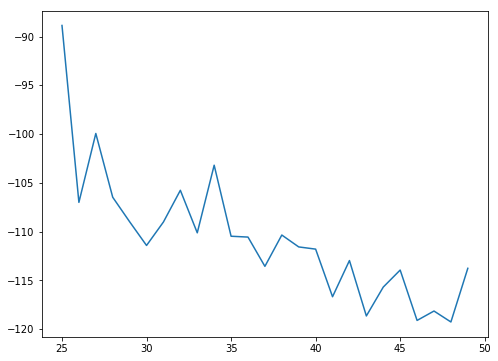

In [21]:
df = pd.DataFrame(history.history)
display(df.describe(percentiles=[0.25 * i for i in range(4)] + [0.95, 0.99]))
col = 'val_loss' if 'val_loss' in df else 'loss'
df[col][-25:].plot(figsize=(8, 6))

# 2019-07-28

* Got some framework up to do coupling layers but having trouble passing the scale parameter to the loss function, getting some weird tensorflow error, needs more debugging
* Without the determinant in the loss function, it looks like loss goes down, so maybe on the right track?
    * It's actually weird that we're not using the image in the output, but I guess that's what's great about this reversible model!
* TODO:
    * Debug scale function in loss
    * Add reverse (generator) network to functions above.

# 2019-07-29

* Explanation of how to estimate probability of continuous variables (relevant for computing bits/pixel without an explicit discrete distribution): https://math.stackexchange.com/questions/2818318/probability-that-a-sample-is-generated-from-a-distribution
* Idea for a post, explain likelihood estimation of discrete vs. continuous distributions (like pixels), include:
  * Probability of observing a value from continuous distribution = 0
     * https://math.stackexchange.com/questions/920241/can-an-observed-event-in-fact-be-of-zero-probability
  * Probability of observing a value from a set of discrete hypthesis (models) is non-zero using epsilon trick (see above link):
     * https://math.stackexchange.com/questions/920241/can-an-observed-event-in-fact-be-of-zero-probability
  * Explain Equation 3 from "A NOTE ON THE EVALUATION OF GENERATIVE MODELS"
     * Also include an example using a simpler case, like a bernoulli variable that we're estimating using a continuous distribution
  * Bring it back to modelling pixels and how they usually do it